# Tensor Networks Assignment 2025/26
## Mar López

In this assignment, we study the real-time evolution of the transverse-field Ising model in a one-dimensional spin-$1/2$ chain with open boundary conditions. The Hamiltonian is
$$
H_{\mathrm{Ising}}(g) = \sum_{i=1}^{N-1} X_i X_{i+1} + g \sum_{i=1}^{N} Z_i \, .
$$

We consider a quantum quench starting from a simple product state $|\psi_0\rangle = |\uparrow\rangle^{\otimes N}$ and evolve it as $|\psi(t)\rangle = e^{-iHt}|\psi_0\rangle$. The goal is to compute the expectation value of the local observable at the center of the chain, $\langle Z_{i=N/2}(t)\rangle$, which probes how local magnetization relaxes.

Since the Hilbert space grows exponentially with system size, we represent the many-body state using a matrix product state (MPS). The time-evolution operator is discretized in steps $\delta t$ and approximated with a Trotter decomposition, leading to a two-dimensional tensor network (space $\times$ time) representation of $\langle \psi(t)|Z_{N/2}|\psi(t)\rangle$. We then evaluate $\langle Z_{i=N/2}(t)\rangle$ using two different tensor-network contraction strategies:

- Standard real-time evolution with MPS (TEBD), contracting the network along the time direction while truncating the MPS bond dimension $\chi$.
- Spatial (transverse) contraction of the corresponding spacetime tensor network, interpreting columns as transfer matrices (MPOs) and contracting along the spatial direction using boundary MPS with controlled truncation.

First, we can import the modules we are going to use.

In [1]:
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib
from ncon import ncon
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import tebd
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain

tenpy.tools.misc.setup_logging(to_stdout="INFO")

## Part I: Expectation value with TEBD

In this section, we compute the expectation value of the local operator $\langle Z_{i=N/2}(t)\rangle$ up to time $T=4$ using TEBD (Time-Evolving Block Decimation). TEBD approximates the time-evolution operator $U(\delta t)=e^{-iH\delta t}$ via a Trotter decomposition, which are applied sequentially to an MPS representation of the state. After each time step, the MPS is truncated to a maximum bond dimension $\chi$ to control the computational cost.

To implement this, we use and adapt the TEBD example provided by TenPy: [A first TEBD Example](https://tenpy.readthedocs.io/en/v1.0.4/notebooks/00_tebd.html). We measure $\langle Z_{i=N/2}(t)\rangle$ at each time step and store the results for comparison with the spatial contraction approach in Part II.

### Model setup and initialization

In this first step we define the physical model, the simulation parameters, and the initial many-body state. We work with a finite transverse-field Ising chain of length $N=50$ with open boundary conditions, coupling strength $J=1$, and transverse field $g=0.7$. The real-time evolution is computed up to a final time $T=4$ using a Trotter time step $\delta t = 0.1$. To keep the numerical cost under control, we restrict the MPS bond dimension to a maximum value $\chi_{\max}=200$.

In [ ]:
N = 50
g = 0.7
T = 4.0
dt = 0.1
chi_max = 200

In [4]:
model_params = {
    'J': 1. ,
    'g': g ,
    'L': N ,
    'bc_MPS': 'finite',
}

M = TFIChain(model_params)

INFO    : TFIChain: reading 'bc_MPS'='finite'
INFO    : TFIChain: reading 'L'=50
INFO    : TFIChain: reading 'J'=1.0
INFO    : TFIChain: reading 'g'=0.7


With the model defined, we initialize the many-body wavefunction as a product-state MPS. The instruction `[['up']]` sets every site of the lattice `M.lat` to the local state $|\uparrow\rangle$ (eigenstate of $Z$ with eigenvalue $+1$). This corresponds to the fully polarized initial state
$|\psi_0\rangle = |\uparrow\uparrow\cdots\uparrow\rangle$.

In [5]:
psi = MPS.from_lat_product_state(M.lat, [['up']])

Next, we specify the TEBD parameters. We choose a second-order Trotter decomposition and a time step `dt=0.1`. The truncation parameters control the MPS compression after each gate application: `chi_max` sets the maximum allowed bond dimension, while `svd_min` discards singular values below a fixed threshold.

Finally, we create the TEBD engine. This engine contains the time-evolution gates generated from the Hamiltonian and provides the routines to evolve the MPS `psi` in time under the model `M`.

In [6]:
tebd_params = {
    'N_steps': 1,
    'dt': dt,
    'order': 2,
    'trunc_params': {'chi_max': chi_max, 'svd_min': 1.e-12}
}

eng = tebd.TEBDEngine(psi, M, tebd_params)

INFO    : TEBDEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')


### Measurement and data collection

After initializing the model and the TEBD engine, the next step is to track how physical properties change during the real-time evolution. Since TEBD updates the MPS state step by step, we define a helper function `measurement` that extracts a set of observables from the current state and appends them to a dictionary. Repeating this procedure at each time step produces a time series that can later be analyzed and plotted. The observables we measure are:

- Entanglement entropy: reveals how quantum correlations grow as the system evolves far from equilibrium.
- Local magnetization: ($\langle \sigma_x \rangle$, $\langle \sigma_z \rangle$) provides insight into the expectation values of individual operators.
- Correlations: ($\langle \sigma_x^i \sigma_x^j \rangle$) characterize how information spreads across the chain.
- Truncation error: monitors the numerical accuracy of our MPS approximation throughout the evolution.

In the loop below, we first record observables at $t=0$ and then repeatedly call eng.run() to advance the state by one time step. After each update, we call measurement again to store the observables at the new time. The resulting dictionary data contains the full evolution history of all measured quantities up to the final time $T$.

In [7]:
def measurement(eng, data):
    """Collect observables from the current TEBD state.
    Args:
        eng: TEBD engine with the current MPS state.
        data: dict of lists or None (initialized if None).
    Returns:
        data: dict with time, entropy, magnetization, correlations, and truncation error.
    """
    keys = ['t', 'entropy', 'Sx', 'Sz', 'corr_XX', 'corr_ZZ', 'trunc_err']
    if data is None:
        data = dict([(k, []) for k in keys])
    data['t'].append(eng.evolved_time)
    data['entropy'].append(eng.psi.entanglement_entropy())
    data['Sx'].append(eng.psi.expectation_value('Sigmax'))
    data['Sz'].append(eng.psi.expectation_value('Sigmaz'))
    data['corr_XX'].append(eng.psi.correlation_function('Sigmax', 'Sigmax'))
    data['corr_ZZ'].append(eng.psi.correlation_function('Sigmaz', 'Sigmaz'))
    data['trunc_err'].append(eng.trunc_err.eps)
    return data

In [8]:
data = measurement(eng, None)
while eng.evolved_time < T:
    eng.run()
    measurement(eng, data)

INFO    : TEBDEngine: reading 'dt'=0.1
INFO    : TEBDEngine: reading 'N_steps'=1
INFO    : TEBDEngine: reading 'order'=2
INFO    : Calculate U for {'order': 2, 'delta_t': 0.1, 'type_evo': 'real', 'E_offset': None, 'tau': 0.1}
INFO    : trunc_params: reading 'chi_max'=100
INFO    : trunc_params: reading 'svd_min'=1e-12
INFO    : --> time=0.100 + 0.000j, max(chi)=4, max(S)=0.05577, avg DeltaS=5.5553e-02, since last update: 0.8s
INFO    : --> time=0.200 + 0.000j, max(chi)=6, max(S)=0.16365, avg DeltaS=1.0752e-01, since last update: 0.5s
INFO    : --> time=0.300 + 0.000j, max(chi)=8, max(S)=0.28594, avg DeltaS=1.2197e-01, since last update: 0.6s
INFO    : --> time=0.400 + 0.000j, max(chi)=9, max(S)=0.40207, avg DeltaS=1.1593e-01, since last update: 0.7s
INFO    : --> time=0.500 + 0.000j, max(chi)=10, max(S)=0.50082, avg DeltaS=9.8668e-02, since last update: 1.0s
INFO    : --> time=0.600 + 0.000j, max(chi)=12, max(S)=0.57815, avg DeltaS=7.7336e-02, since last update: 0.6s
INFO    : --> time

### Results: observable dynamics during time evolution

In order to characterize the TEBD time evolution, we visualize several observables extracted from the dataset `data`. These quantities provide complementary information about the system dynamics.

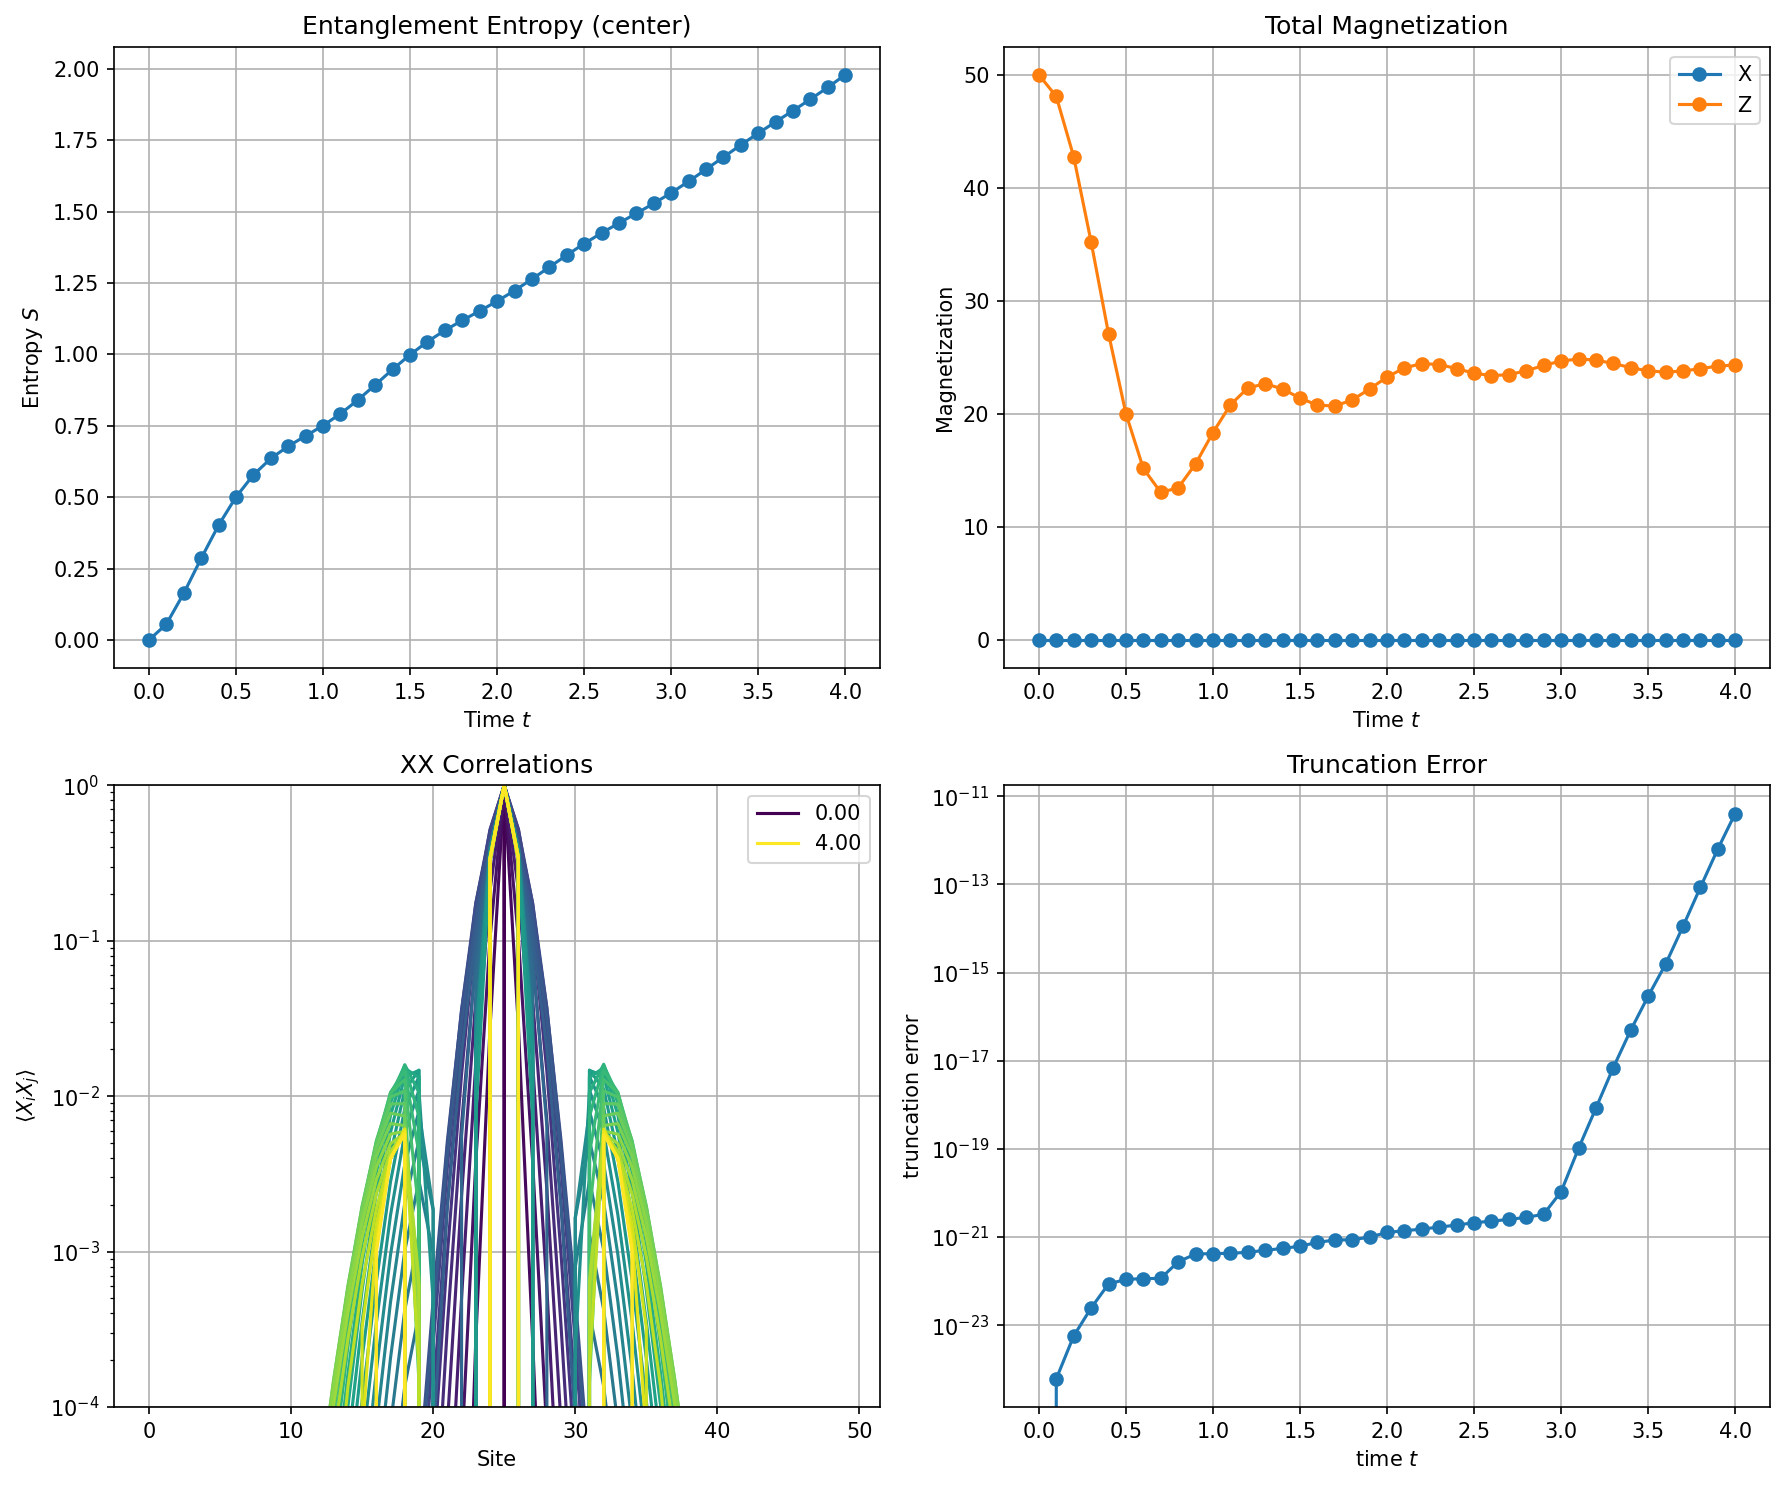

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Entanglement entropy at center
axes[0, 0].plot(data['t'], np.array(data['entropy'])[:, N//2], 'o-')
axes[0, 0].set_xlabel('Time $t$')
axes[0, 0].set_ylabel('Entropy $S$')
axes[0, 0].set_title('Entanglement Entropy (center)')
axes[0, 0].grid(True)

# Plot 2: Magnetization
axes[0, 1].plot(data['t'], np.sum(data['Sx'], axis=1), 'o-', label='X')
axes[0, 1].plot(data['t'], np.sum(data['Sz'], axis=1), 'o-', label='Z')
axes[0, 1].set_xlabel('Time $t$')
axes[0, 1].set_ylabel('Magnetization')
axes[0, 1].set_title('Total Magnetization')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True)

# Plot 3: Correlations
corrs = np.array(data['corr_XX'])
tmax = data['t'][-1]
x = np.arange(N)
cmap = matplotlib.cm.viridis
for i, t in list(enumerate(data['t'])):
    if i == 0 or i == len(data['t']) - 1:
        label = '{t:.2f}'.format(t=t)
    else:
        label = None
    axes[1, 0].plot(x, corrs[i, N//2, :], color=cmap(t/tmax), label=label)
axes[1, 0].set_xlabel(r'Site')
axes[1, 0].set_ylabel(r'$\langle X_i X_j \rangle$')
axes[1, 0].set_title('XX Correlations')
axes[1, 0].set_yscale('log')
axes[1, 0].set_ylim(1.e-4, 1.)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Truncation error
axes[1, 1].plot(data['t'], data['trunc_err'], 'o-')
axes[1, 1].set_yscale('log')
#plt.ylim(1.e-15, 1.)
axes[1, 1].set_xlabel('time $t$')
axes[1, 1].set_ylabel('truncation error')
axes[1, 1].set_title('Truncation Error')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

- Entanglement entropy (top-left): Shows the von Neumann entropy $S = -\text{Tr}(\rho\log\rho)$ at the center bond (site $N/2$). Since the initial product state has zero entanglement, the increase of entropy indicates the growth of quantum correlations as the system evolves from the initially separable product state.

- Total magnetization (top-right): Tracks the total magnetization $\sum_i\langle\sigma_x^i\rangle$ (blue) and $\sum_i\langle\sigma_z^i\rangle$ (orange) over the full chain. Initially, the state is fully polarized along $z$, so the total $z$-magnetization starts at its maximum value. Under the transverse-field Ising Hamiltonian, magnetization components generally oscillate and its decay reveals how the system moves away from the $\ket{\uparrow}$ product state as quantum dynamics mix the spin configurations.

- Spatial correlations (bottom-left): Displays two-point correlation functions $\langle X_i X_j\rangle$ as a function of the site. Different curves (color-coded by time) show how correlations spread spatially.

- Truncation error (bottom-right): Monitors the discarded weight accumulated from SVD truncations performed during TEBD. The low values confirm that our maximum bond dimension $\chi_{\max}=200$ provides highly accurate results throughout the evolution. Sudden increases in truncation error indicate moments when the quantum state becomes more entangled.

Finally, we focus on the main quantity of interest for Part I: the expectation value of the local operator at the center of the chain, $\langle Z_{i=N/2}(t)\rangle$. We extract it directly from the site-resolved $z$-magnetization measurements stored in data['Sz'] by selecting the entry at site $i=N/2$ for each time step. The resulting curve shows the oscillatory real-time response of the local magnetization under TFIM dynamics from $t=0$ up to $t=T$.

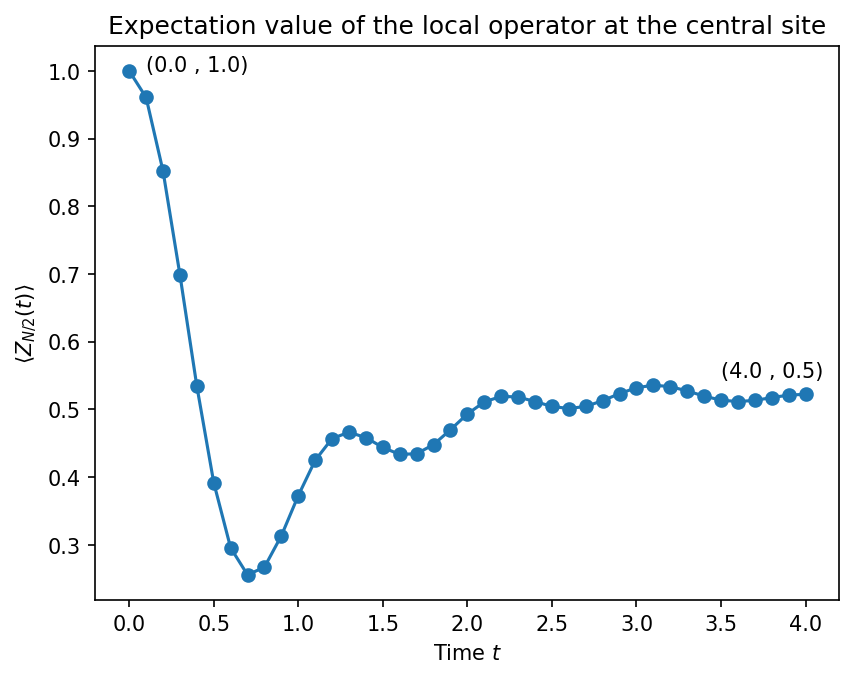

In [10]:
# Extract the expectation value of Z at the center site (i=N/2) at each time step
z_center = np.array([z[N//2] for z in data['Sz']])

# Plot 5: Magnetization at the central site
plt.plot(data['t'], z_center, 'o-')
plt.xlabel('Time $t$')
plt.ylabel('$\\langle Z_{N/2}(t) \\rangle$')
plt.title('Expectation value of the local operator at the central site')
# Add text annotations for initial and final values
plt.text(data['t'][0] + 0.1, z_center[0], f"({data['t'][0]:.1f} , {z_center[0]:.1f})", ha='left')
plt.text(data['t'][-1] -0.2, z_center[-1] + 0.02, f'({data["t"][-1]:.1f} , {z_center[-1]:.1f})', va='bottom', ha='center')
plt.show()

## Part II: Expectation value via transverse contraction

In this part we compute the same local observable, $\langle Z_{i=N/2}(t)\rangle$, but using a different contraction strategy for the underlying spacetime tensor network. Instead of evolving the quantum state forward in time as an MPS (as done in TEBD), we start from the tensor network representation of $\langle \psi(t)|Z_{N/2}|\psi(t)\rangle$ generated by the Trotter decomposition and contract it along the spatial direction.

The key idea is to interpret each vertical column of the spacetime network as a transfer matrix $E$ written in matrix product operator (MPO) form. Contracting the full network then reduces to repeatedly applying this MPO to boundary states represented as MPS, while truncating their bond dimension to keep the computation efficient. Since the transfer matrix is not unitary, intermediate norms can grow or decay quickly; therefore, the expectation value is evaluated using a normalized ratio of contractions, $\langle L|E_{\mathrm{op}}|R\rangle / \langle L|E|R\rangle$, where $E_{\mathrm{op}}$ denotes the column containing the local operator insertion.

In the following subsections we construct the transfer matrix columns, build the left and right boundary MPS via iterative contraction with controlled truncation, and finally compute $\langle Z_{N/2}(t)\rangle$ and compare it with the TEBD results from Part I.

### Identify columns of the tensor network as transfer matrices E in MPO form

To perform the spatial contraction of the spacetime tensor network, we need to reorganize the TEBD evolution gates into transfer matrices that represent vertical columns of the network. The goal of this step is to rewrite the Trotterized real-time evolution as a set of local MPO tensors that can later be contracted from left to right (along the spatial direction).

The key idea is to swap the role of physical and virtual indices. In the TEBD gates, the spins are the pysical indices $(d=2)$, but, after reorganizing the network into columns, these become the indices running vertically through the column. On the other hand, the virtual indices connecting sites in the standard TEBD approximation, become the spacial bonds that connect columns.

We implement this in two steps:

1. Gate Decomposition (`split_gate_to_mpo_tensors`):

Each two-body TEBD gate $U_{i,i+1}$ acting on neighboring sites is decomposed via SVD into two three-leg tensors $M_{\text{left}}$ and $M_{\text{right}}$.

2. Transfer Matrix Construction (`build_step_transfer_matrices` and `build_transfer_matrices_columns`):

For each Trotter substep, we collect the local contribution acting on a given site coming from (i) the gate on the bond to its left and (ii) the gate on the bond to its right. We then combine these two contributions into a single four-leg tensor $E^{[i]}$ for that site and substep. Repeating this for all sites and all substeps produces `E_one_step[site][substep]`, which represents one full time step $\delta t$ in a column-wise MPO form. Then, concatenating many copies of this list we construct the `E` transfer matrices.

In [50]:
def split_gate_to_mpo_tensors(gate):
    """Split a 2-body TEBD gate into 1-body MPO tensors for spatial columns via SVD.
    
    The TEBD gate has shape (2, 2, 2, 2) with legs ordered as (s_i, s_j, s_i', s_j'):
    - s_i, s_j: input physical indices for sites bond_index-1 and bond_index
    - s_i', s_j': output physical indices for sites bond_index-1 and bond_index
    
    We transpose to group site pairs: (s_i, s_i', s_j, s_j'),
    then SVD factorizes the gate to split it between left and right spatial positions.
    
    Args:
        gate: (2,2,2,2) complex ndarray representing a 2-body TEBD gate
    
    Returns:
        M_left: (2, 2, D) left MPO tensor for spatial site bond_index-1 (format: s_i, s_i', D)
        M_right: (D, 2, 2) right MPO tensor for spatial site bond_index (format: D, s_j, s_j')
        where D is the SVD bond dimension (rank of factorization)
    """

    # Convert gate from npc array to numpy array
    gate = gate.to_ndarray()
    
    # Transpose to group indices for each site.
    gate_reordered = np.transpose(gate, (0, 2, 1, 3))
    
    # Reshape into 2D matrix (4, 4) for SVD: rows for site i and columns for site j
    mat = gate_reordered.reshape(4, 4)
    U, S, Vh = LA.svd(mat, full_matrices=False)
    
    # Split singular values equally
    U_left = U @ np.diag(np.sqrt(S))
    V_right = np.diag(np.sqrt(S)) @ Vh
    
    # Reshape to MPO form: (phys, phys', virtual)
    M_left = U_left.reshape(2, 2, -1)   # (s_i, s_i', D)
    M_right = V_right.reshape(-1, 2, 2) # (D, s_j, s_j')
    
    return M_left, M_right

In [51]:
def build_step_transfer_matrices(U_layers):
    """Build transfer matrices E from TEBD gates for one time step (dt).
    
    Args:
        U_layers: list of Trotter sub-steps from eng._U (unique even/odd gates)
    
    Returns:
        E: list of transfer matrix with shape (2, 2, D_left, D_right) where:
           - (2, 2) are spatial bonds
           - (D_left, D_right) are temporal bonds
    """

    # Full Trotter schedule used by eng.evolve
    order = tebd_params["order"]
    n_steps = tebd_params["N_steps"]
    schedule = eng.suzuki_trotter_decomposition(order, n_steps)
    
    E_one_step = []  # E_one_step[site][substep]
    
    # Loop over all spatial sites
    for site_index in range(N):
        E_site = []  # List of transfer matrices for this site at one time step
        
        # Loop over the full Suzuki-Trotter schedule
        for U_idx_dt, odd in schedule:
            substep = U_layers[U_idx_dt]
            
            # Contribution from LEFT bond (site_index-1, site_index)
            left_bond = site_index
            left_active = (left_bond % 2) == odd
            if site_index > 0 and left_active and substep[left_bond] is not None:
                gate_left = substep[left_bond]
                M_left, M_right = split_gate_to_mpo_tensors(gate_left)
                # This site gets M_right part: (D, 2, 2) -> transpose to (2, 2, D)
                E_from_left = np.transpose(M_right, (1, 2, 0))
            else:
                # Boundary or no gate: use identity
                E_from_left = np.eye(2, dtype=complex).reshape(2, 2, 1)

            # Contribution from RIGHT bond (site_index, site_index+1)
            right_bond = site_index + 1
            right_active = (right_bond % 2) == odd
            if site_index < N - 1 and right_active and substep[right_bond] is not None:
                gate_right = substep[right_bond]
                M_left, M_right = split_gate_to_mpo_tensors(gate_right)
                # This site gets M_left part: already (2, 2, D)
                E_from_right = M_left
            else:
                # Boundary or no gate: use identity
                E_from_right = np.eye(2, dtype=complex).reshape(2, 2, 1)
            
            # Combine contributions: (2, 2, D_left) x (2, 2, D_right) -> (2, 2, D_left, D_right)
            E_substep = np.einsum('ijk,ijl->ijkl', E_from_left, E_from_right)
            E_site.append(E_substep)
        
        E_one_step.append(E_site)
    
    return E_one_step

In [52]:
E_one_step = build_step_transfer_matrices(eng._U)

In [53]:
print("Structure of the transfer matrices for one time step\n")
print(f"Structure: E[site][substep]")
print(f"Number of sites: {len(E_one_step)}")
print(f"Number of substeps per time step: {len(E_one_step[0])}\n")

print(f"Shape of E[{N//2}][0] (center site, first substep):")
print(f"  {E_one_step[N//2][0].shape} = (2, 2, D_left, D_right)")

Structure of the transfer matrices for one time step

Structure: E[site][substep]
Number of sites: 50
Number of substeps per time step: 3

Shape of E[25][0] (center site, first substep):
  (2, 2, 4, 1) = (2, 2, D_left, D_right)


At this stage, `E_one_step` contains the set of local MPO tensors needed to represent a single Trotter time step $\delta t$. The printed shapes are a quick sanity check: for bulk sites we obtain $(2,2,4,4)$, while boundary sites reduce the corresponding auxiliary dimensions to 1.

To contract the full expectation value $\langle \psi(t)|O|\psi(t)\rangle$ as a spacetime tensor network, we need to include both the forward (ket) and backward (bra) evolutions. In the unfolded representation, this is implemented by stacking:

- a bottom boundary corresponding to the initial product state,

- all forward Trotter layers (ket),

- all backward layers in reverse order (bra), where each layer uses the Hermitian conjugate gate,

- the top boundary associated with the bra.

In the code below, we build for each spatial site a list E[site] that stores the full vertical sequence of tensors forming the bra–ket “sandwich” for a chosen final time $T$. The dagger of each transfer tensor is implemented as complex conjugation together with a swap of the $(2,2)$ input/output legs.

In [54]:
def build_transfer_matrices_columns(E_one_step, T=T):
    """Build complete spacetime columns for all sites, combining ket and bra in a sandwich structure.
    
    For each spatial site, this function builds a vertical column that represents the full
    spacetime tensor network slice at that position. Each column contains (from bottom to top):
    
    1. Initial MPS tensor (ket side): psi[site] with shape (D_left, d_phys, D_right)
    2. Time evolution gates (ket side): Transfer matrices E for each time step
    3. Time evolution gates (bra side): Transfer matrices E† in reverse order
    4. Initial MPS tensor (bra side): psi[site]† with shape (D_left, d_phys, D_right)
    
    This creates the full bra-ket sandwich: ⟨ψ(T)| ... |ψ(0)⟩ for spatial contraction.
    
    Args:
        E_one_step: Transfer matrices for one time step, structure E_one_step[site][substep]
                    Each E has shape (d_in, d_out, D_left, D_right)
        T: Final time to evolve to (default: global T)
        
    Returns:
        E: Structure E[site][layer_idx] where each site contains the full vertical column:
           - First layers: initial MPS + forward time evolution (ket |ψ⟩)
           - Last layers: backward time evolution + initial MPS adjoint (bra ⟨ψ|)
    """

    psi_initial = MPS.from_lat_product_state(M.lat, [['up']])
    
    # Calculate number of time steps needed to reach T
    num_time_steps = int(np.round(T / dt))
    num_substeps = len(E_one_step[0])
    
    E_full = []
    E_full_adj = []
    
    # Build column for each spatial site
    for site in range(N):

        column = []
        column_adj = []
        
        # First layer: initial MPS tensor at this site
        initial_tensor = psi_initial.get_B(site).to_ndarray()  # (D_left, d_phys, D_right)
        column.append(initial_tensor)
        column_adj.append(np.conj(initial_tensor))
        
        # Subsequent layers: apply E_one_step for each time step
        for time_step in range(num_time_steps):
            for substep in range(num_substeps):
                E_tensor = E_one_step[site][substep]  # (d_in, d_out, D_left, D_right)
                column.append(E_tensor)
                column_adj.append(np.conj(E_tensor).transpose(1, 0, 2, 3))
        
        E_full.append(column)
        E_full_adj.append(column_adj)
    
    E = []
    for site in range(N):
        E_site = []
        for i in E_full[site]: E_site.append(i)
        for j in range(len(E_full_adj[site])):
            E_site.append(E_full_adj[site][len(E_full_adj[site]) - 1 - j])
        E.append(E_site)
    
    return E

In [ ]:
# Build the full spacetime columns (ket-bra sandwich structure)
E = build_transfer_matrices_columns(E_one_step, T=0.2)

In [56]:
print(f"\nStructure of E (complete bra-ket sandwich):")
print(f"  E[site][layer_idx]")
print(f"  Number of sites: {len(E)}")
print(f"  Total layers per site: {len(E[0])}")
print(f"    - Ket side (bottom): {len(E[0])//2} layers")
print(f"    - Bra side (top): {len(E[0])//2} layers")

print(f"\nExample shapes:")
print(f"  E[0][0] (site 0, initial MPS ket): {E[0][0].shape}")
print(f"  E[0][1] (site 0, first transfer matrix ket): {E[0][1].shape}")
print(f"  E[0][-2] (site 0, first transfer matrix bra): {E[0][-2].shape}")
print(f"  E[0][-1] (site 0, initial MPS bra): {E[0][-1].shape}")
print(f"\n  E[{N//2}][0] (center site, initial MPS ket): {E[N//2][0].shape}")
print(f"  E[{N//2}][-1] (center site, initial MPS bra): {E[N//2][-1].shape}")


Structure of E (complete bra-ket sandwich):
  E[site][layer_idx]
  Number of sites: 50
  Total layers per site: 8
    - Ket side (bottom): 4 layers
    - Bra side (top): 4 layers

Example shapes:
  E[0][0] (site 0, initial MPS ket): (1, 2, 1)
  E[0][1] (site 0, first transfer matrix ket): (2, 2, 1, 4)
  E[0][-2] (site 0, first transfer matrix bra): (2, 2, 1, 4)
  E[0][-1] (site 0, initial MPS bra): (1, 2, 1)

  E[25][0] (center site, initial MPS ket): (1, 2, 1)
  E[25][-1] (center site, initial MPS bra): (1, 2, 1)


This print provides a basic consistency check of the constructed columns: each site now carries a list of layers that includes the bottom boundary (initial state), the forward evolution, the backward evolution in reverse order, and the top boundary. In the next subsections, these column objects will be contracted along the spatial direction using boundary MPS and controlled truncation to avoid exponential growth of intermediate tensor dimensions.

### Define the effective states $\bra{L}$ and $\ket{R}$

After identifying each spacetime column as a local transfer matrix object, the next step in the spatial (transverse) contraction is to build the two effective boundary states:
- the left effective state $\langle L|$, obtained by contracting all columns from the left boundary up to (but not including) the operator column,
- the right effective state $|R\rangle$, obtained by contracting all columns from the right boundary up to the operator column.

A direct, exact contraction of many columns would lead to an exponential growth of intermediate tensor dimensions. To avoid this, we compress the intermediate objects after each spatial contraction step using SVD truncation. In practice, this plays the same role as MPS truncation in TEBD: we keep only the most relevant singular values and limit the effective dimension by enforcing a maximum cutoff $\chi_{\max}$.

In the code below, we implement this idea by iteratively updating a “left environment” and a “right environment”:
- `left_effective_state(E)` starts from the first column and repeatedly absorbs columns moving rightwards until the center.
- `right_effective_state(E)` starts from the last column and repeatedly absorbs columns moving leftwards until the center.

Because our unfolded construction stores different tensor types in the vertical direction (boundary MPS tensors at the bottom/top layers and transfer-matrix tensors in the middle layers), the contraction is handled in two separate cases:
1. Boundary layers (`layer_idx == 0` or `layer_idx == num_layers-1`): these are rank-3 tensors coming from the initial state (ket) and its conjugate (bra). We contract them with the corresponding boundary tensor of the next column and then truncate/compress.
2. Transfer-matrix layers (all other layers): these are rank-4 tensors with shape $(2,2,D_L,D_R)$. We contract the current effective layer tensor with the next column tensor, and then perform SVD-based truncations to control the growth of both the horizontal bond dimension and the “temporal” effective dimension.

Finally, we normalize each updated layer tensor to avoid numerical overflow/underflow (the transfer matrix is not unitary), and we store the truncation errors and kept bond dimensions for diagnostic purposes.

In [ ]:
def truncate_to_fixed_dim(mat, target_dim):
    """Truncate a matrix to a fixed target dimension using SVD, keeping the largest singular values.
    Args:
        mat: (k, M) matrix to be truncated to (target_dim, M)
        target_dim: desired output dimension (chi_max)
    
    Returns:
        mat_fixed: (target_dim, M)
        trunc_error: discarded singular values norm
    """
    U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')

    kept = min(len(S), target_dim)
    trunc_error = np.sqrt(np.sum(S[kept:]**2)) if len(S) > kept else 0.0

    # Keep only the first 'kept' singular values
    mat_trunc = np.diag(S[:kept]) @ Vh[:kept, :]

    # Pad with zeros if needed
    if kept < target_dim:
        pad = np.zeros((target_dim - kept, mat_trunc.shape[1]), dtype=mat_trunc.dtype)
        mat_trunc = np.concatenate([mat_trunc, pad], axis=0)

    return mat_trunc, trunc_error

In [58]:
def left_effective_state(E):
    """Compute the left effective boundary state by contracting the spacetime columns from the left, applying SVD truncation at each step.
    Args:
        E: list of spacetime columns for each site, structure E[site][layer_idx]
    Returns:
        state_L: list of effective boundary states for each layer at the final contracted site
        trunc_errors: list of truncation errors at each contraction step
        bond_dims: list of bond dimensions kept at each step
    """

    num_sites = len(E)
    num_layers = len(E[0])

    trunc_errors = []
    bond_dims = []

    # Initial state_L = first column
    state_L = [E[0][layer] for layer in range(num_layers)]

    for site in range(1, num_sites // 2):
        # print(f"Contracting site {site}:")
        new_state_L = []

        for layer_idx in range(num_layers):
            state_tensor = state_L[layer_idx]
            column_tensor = E[site][layer_idx]

            #  CASE 1: MPS LAYER (bottom/top)
            if layer_idx == 0 or layer_idx == num_layers - 1:
                # print(f"    Contracting MPS matrix: state {state_tensor.shape} x column {column_tensor.shape}")

                contracted = ncon(
                    [state_tensor, column_tensor],
                    [[-1, -2, 1], [1, -3, -4]]
                )  # (D_l, d_l, d_r, D_r)

                D_l, d_l, d_r, D_r = contracted.shape
                contracted = contracted.reshape(D_l, d_l * d_r, D_r)

                # SVD on right bond
                mat = contracted.reshape(D_l * (d_l * d_r), D_r)
                U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')
                chi = min(len(S), chi_max)
                trunc_error = np.sqrt(np.sum(S[chi:]**2)) if len(S) > chi else 0.0
                mat_trunc = (U[:, :chi] @ np.diag(S[:chi]))
                tensor_trunc = mat_trunc.reshape(D_l, d_l * d_r, chi)

                # Temporal truncation
                d_phys = tensor_trunc.shape[1]
                mat_t = tensor_trunc.reshape(d_phys, D_l * chi)
                mat_t_fixed, trunc_error_t = truncate_to_fixed_dim(mat_t, chi_max)
                trunc_error = np.sqrt(trunc_error**2 + trunc_error_t**2)

                tensor_trunc = mat_t_fixed.reshape(chi_max, D_l, chi).transpose(1, 0, 2) # final shape: (D_l, chi_max, chi)

            #  CASE 2: TRANSFER MATRIX LAYER
            else:
                # print(f"    Contracting transfer matrix: state {state_tensor.shape} x column {column_tensor.shape}")
                contracted = ncon(
                    [state_tensor, column_tensor],
                    [[-1, -3, -5, 1], [-2, -4, 1, -6]]
                )  # (d_in1, d_in2, d_out1, d_out2, D_l, D_r)

                d1, d2, o1, o2, D_l, D_r = contracted.shape
                contracted = contracted.reshape(d1 * d2, o1 * o2, D_l, D_r)
                d_in, d_out, D_l, D_r = contracted.shape

                # SVD on right bond
                mat = contracted.reshape(d_in * d_out * D_l, D_r)
                U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')
                chi = min(len(S), chi_max)
                trunc_error = np.sqrt(np.sum(S[chi:]**2)) if len(S) > chi else 0.0
                mat_trunc = U[:, :chi] @ np.diag(S[:chi])
                tensor_trunc = mat_trunc.reshape(d_in, d_out, D_l, chi)

                # Temporal truncation on d_in
                mat_in = tensor_trunc.reshape(d_in, d_out * D_l * chi)
                mat_in_fixed, trunc_error_in = truncate_to_fixed_dim(mat_in, chi_max)
                tensor_trunc = mat_in_fixed.reshape(chi_max, d_out, D_l, chi)

                # Temporal truncation on d_out
                tensor_trunc = tensor_trunc.transpose(1, 0, 2, 3)
                mat_out = tensor_trunc.reshape(d_out, chi_max * D_l * chi)
                mat_out_fixed, trunc_error_out = truncate_to_fixed_dim(mat_out, chi_max)
                tensor_trunc = mat_out_fixed.reshape(chi_max, chi_max, D_l, chi).transpose(1, 0, 2, 3)

                trunc_error = np.sqrt(trunc_error**2 + trunc_error_in**2 + trunc_error_out**2)

            # Normalize
            norm = np.linalg.norm(tensor_trunc)
            if norm > 1e-14:
                tensor_trunc /= norm

            new_state_L.append(tensor_trunc)
            trunc_errors.append(trunc_error)
            bond_dims.append(chi)

            # print(f"   Final truncated shape: {tensor_trunc.shape})")

        state_L = new_state_L
        # print(f"  Site {site} complete\n")

    return state_L, trunc_errors, bond_dims


In [59]:
left_state, left_trunc_errs, left_bond_dims = left_effective_state(E)

In [60]:
def right_effective_state(E):
    """Compute the right effective boundary state |R> by contracting the spacetime columns from the right, applying SVD truncation at each step.
    Args:
        E: list of spacetime columns for each site, structure E[site][layer_idx]
    Returns:
        state_R: list of effective boundary states for each layer at the final contracted site
        trunc_errors: list of truncation errors at each contraction step
        bond_dims: list of bond dimensions kept at each step
    """

    N = len(E)
    num_layers = len(E[0])

    trunc_errors = []
    bond_dims = []

    # Initialize: state_R is a list of tensors, one for each layer
    state_R = [E[N - 1][layer_idx] for layer_idx in range(num_layers)]

    for site in range(N - 2, N // 2, -1):
        # print(f"Contracting site {site}:")
        new_state_R = []

        for layer_idx in range(num_layers):
            state_tensor = state_R[layer_idx]
            column_tensor = E[site][layer_idx]

            #  CASE 1: MPS LAYER (bottom/top)
            if layer_idx == 0 or layer_idx == num_layers - 1:
                # print(f"    Contracting MPS matrix: state {state_tensor.shape} x column {column_tensor.shape}")
                contracted = ncon(
                    [column_tensor, state_tensor],
                    [[-1, -2, 1], [1, -3, -4]]
                )  # (D_l, d_l, d_r, D_r)

                D_l, d_l, d_r, D_r = contracted.shape
                contracted = contracted.reshape(D_l, d_l * d_r, D_r)

                # SVD on right bond
                mat = contracted.reshape(D_l * (d_l * d_r), D_r)
                U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')
                chi = min(len(S), chi_max)
                trunc_error = np.sqrt(np.sum(S[chi:]**2)) if len(S) > chi else 0.0
                mat_trunc = U[:, :chi] @ np.diag(S[:chi])
                tensor_trunc = mat_trunc.reshape(D_l, d_l * d_r, chi)

                # Temporal truncation
                d_phys = tensor_trunc.shape[1]
                mat_t = tensor_trunc.reshape(d_phys, D_l * chi)
                mat_t_fixed, trunc_error_t = truncate_to_fixed_dim(mat_t, chi_max)
                trunc_error = np.sqrt(trunc_error**2 + trunc_error_t**2)

                tensor_trunc = mat_t_fixed.reshape(chi_max, D_l, chi).transpose(1, 0, 2) # final shape: (D_l, chi_max, chi)

            #  CASE 2: TRANSFER MATRIX LAYER
            else:
                # print(f"    Contracting transfer matrix: state {state_tensor.shape} x column {column_tensor.shape}")
                contracted = ncon(
                    [column_tensor, state_tensor],
                    [[-1, -3, -5, 1], [-2, -4, 1, -6]]
                )  # (d_in1, d_in2, d_out1, d_out2, D_l, D_r)

                d1, d2, o1, o2, D_l, D_r = contracted.shape
                contracted = contracted.reshape(d1 * d2, o1 * o2, D_l, D_r)
                d_in, d_out, D_l, D_r = contracted.shape

                # SVD on right bond
                mat = contracted.reshape(d_in * d_out * D_l, D_r)
                U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')
                chi = min(len(S), chi_max)
                trunc_error = np.sqrt(np.sum(S[chi:]**2)) if len(S) > chi else 0.0
                mat_trunc = U[:, :chi] @ np.diag(S[:chi])
                tensor_trunc = mat_trunc.reshape(d_in, d_out, D_l, chi)

                # Temporal truncation on d_in
                mat_in = tensor_trunc.reshape(d_in, d_out * D_l * chi)
                mat_in_fixed, trunc_error_in = truncate_to_fixed_dim(mat_in, chi_max)

                tensor_trunc = mat_in_fixed.reshape(chi_max, d_out, D_l, chi)

                # Temporal truncation on d_out
                tensor_trunc = tensor_trunc.transpose(1, 0, 2, 3)  # (d_out, chi_max, D_l, chi)
                mat_out = tensor_trunc.reshape(d_out, chi_max * D_l * chi)
                mat_out_fixed, trunc_error_out = truncate_to_fixed_dim(mat_out, chi_max)
                tensor_trunc = mat_out_fixed.reshape(chi_max, chi_max, D_l, chi).transpose(1, 0, 2, 3) # final shape: (chi_max, chi_max, D_l, chi)

                trunc_error = np.sqrt(trunc_error**2 + trunc_error_in**2 + trunc_error_out**2)

            # Normalize
            norm = np.linalg.norm(tensor_trunc)
            if norm > 1e-14:
                tensor_trunc /= norm

            new_state_R.append(tensor_trunc)
            trunc_errors.append(trunc_error)
            bond_dims.append(chi)

            # print(f"   Final truncated shape: {tensor_trunc.shape})")

        state_R = new_state_R
        # print(f"  Site {site} complete\n")

    return state_R, trunc_errors, bond_dims


In [61]:
right_state, right_trunc_errs, right_bond_dims = right_effective_state(E)

Now we can print norms of a few representative layers to verify that the effective boundary tensors remain finite and properly normalized.

In [63]:
print("Norm of left_state[0] (initial left MPS):", np.linalg.norm(left_state[0]))
print("Norm of left_state[-1] (final left MPS):", np.linalg.norm(left_state[-1]))
print("Norm of right_state[0] (initial right MPS):", np.linalg.norm(right_state[0]))
print("Norm of right_state[-1] (final right MPS):", np.linalg.norm(right_state[-1]))
print("Norm of E[N//2][0] (central tensor, initial layer):", np.linalg.norm(E[N//2][0]))
print("Norm of E[N//2][-1] (central tensor, final layer):", np.linalg.norm(E[N//2][-1]))

Norm of left_state[0] (initial left MPS): 1.0
Norm of left_state[-1] (final left MPS): 1.0
Norm of right_state[0] (initial right MPS): 1.0
Norm of right_state[-1] (final right MPS): 1.0
Norm of E[N//2][0] (central tensor, initial layer): 1.0
Norm of E[N//2][-1] (central tensor, final layer): 1.0


### Computation of the expectation value $\langle Z_{i=N/2} (t)\rangle$

In [ ]:
def contract_LER(left_state, E_center, right_state):
    
    num_layers = len(left_state)

    # 1) L ⊗ E_center
    mid_L = []
    for layer_idx in range(num_layers):
        L = left_state[layer_idx]
        E = E_center[layer_idx]

        is_MPS = (layer_idx == 0 or layer_idx == num_layers - 1)
        print(f"\nLayer {layer_idx}/{num_layers-1}  ({'MPS' if is_MPS else 'Transfer'})")
        print(f"  L shape: {L.shape}")
        print(f"  E_center shape: {E.shape}")
        
        if layer_idx == 0 or layer_idx == num_layers - 1:
            print("  [PAS1] Contractant MPS L ⊗ E_center")
            contracted = ncon([L, E], [[-1, -2, 1], [1, -3, -4]])
            print(f"    contracted shape: {contracted.shape}")

            D_l, d_l, d_r, D_r = contracted.shape
            contracted = contracted.reshape(D_l, d_l * d_r, D_r)
            print(f"    reshape (D_l, d_l*d_r, D_r): {contracted.shape}")

            mat = contracted.reshape(D_l * (d_l * d_r), D_r)
            print(f"    mat for SVD: {mat.shape}")
            U, S, Vh = LA.svd(mat, full_matrices=False)
            chi = min(len(S), chi_max)
            print(f"    keeping chi = {chi}")

            mat_trunc = U[:, :chi] @ np.diag(S[:chi])
            tensor = mat_trunc.reshape(D_l, d_l * d_r, chi)
            print(f"    after SVD trunc: {tensor.shape}")

            d_phys = tensor.shape[1]
            mat_t = tensor.reshape(d_phys, D_l * chi)
            print(f"    mat_t for temporal trunc: {mat_t.shape}")
            mat_t_fixed, _ = truncate_to_fixed_dim(mat_t, chi_max)
            print(f"    mat_t_fixed shape: {mat_t_fixed.shape}")

            tensor = mat_t_fixed.reshape(chi_max, D_l, chi).transpose(1, 0, 2)
            print(f"    final mid_L MPS shape: {tensor.shape}")

        else:
            print("  [PAS1] Contractant TRANSFER L ⊗ E_center")
            contracted = ncon(
                [L, E],
                [[-1, -3, -5, 1], [-2, -4, 1, -6]]
            )
            print(f"    contracted shape: {contracted.shape}")

            d1, d2, o1, o2, D_l, D_r = contracted.shape
            contracted = contracted.reshape(d1 * d2, o1 * o2, D_l, D_r)
            print(f"    reshape (d_in, d_out, D_l, D_r): {contracted.shape}")

            d_in, d_out, D_l, D_r = contracted.shape
            mat = contracted.reshape(d_in * d_out * D_l, D_r)
            print(f"    mat for SVD: {mat.shape}")
            U, S, Vh = LA.svd(mat, full_matrices=False)
            chi = min(len(S), chi_max)
            print(f"    keeping chi = {chi}")

            mat_trunc = U[:, :chi] @ np.diag(S[:chi])
            tensor = mat_trunc.reshape(d_in, d_out, D_l, chi)
            print(f"    after SVD trunc: {tensor.shape}")

            # truncació temporal d_in
            mat_in = tensor.reshape(d_in, d_out * D_l * chi)
            print(f"    mat_in for trunc: {mat_in.shape}")
            mat_in_fixed, _ = truncate_to_fixed_dim(mat_in, chi_max)
            print(f"    mat_in_fixed shape: {mat_in_fixed.shape}")
            tensor = mat_in_fixed.reshape(chi_max, d_out, D_l, chi)

            # truncació temporal d_out
            tensor = tensor.transpose(1, 0, 2, 3)
            mat_out = tensor.reshape(d_out, chi_max * D_l * chi)
            print(f"    mat_out for trunc: {mat_out.shape}")
            mat_out_fixed, _ = truncate_to_fixed_dim(mat_out, chi_max)
            print(f"    mat_out_fixed shape: {mat_out_fixed.shape}")

            tensor = mat_out_fixed.reshape(chi_max, chi_max, D_l, chi).transpose(1, 0, 2, 3)
            print(f"    mid_L TRANSFER shape (abans de col·lapsar D): {tensor.shape}")

        norm = np.linalg.norm(tensor)
        if norm > 1e-14:
            tensor /= norm

        mid_L.append(tensor)

    # 2) mid_L ⊗ R
    mid_LR = []

    for layer_idx in range(num_layers):
        L = mid_L[layer_idx]
        R = right_state[layer_idx]

        is_MPS = (layer_idx == 0 or layer_idx == num_layers - 1)
        print(f"\nLayer {layer_idx}/{num_layers-1}  ({'MPS' if is_MPS else 'Transfer'})")
        print(f"  mid_L shape: {L.shape}")
        print(f"  R shape: {R.shape}")

        if is_MPS:
            print("  [PAS2] Contractant MPS mid_L ⊗ R")
            C = np.tensordot(L, R, axes=([2], [0]))  # (1, chi, chi, 1)

            M = C.reshape(chi_max, chi_max)
            U, S, Vh = np.linalg.svd(M, full_matrices=False)

            v = U[:, 0] * S[0]

            v_trunc, _ = truncate_to_fixed_dim(v.reshape(-1, 1), chi_max)
            v_trunc = v_trunc.reshape(chi_max)

            tensor = v_trunc.reshape(1, chi_max, 1)

        else:
            print("  [PAS2] Contractant TRANSFER mid_L ⊗ R (producte de transferències)")

            chiL1, chiL2, DmL, DrL = L.shape
            chiR1, chiR2, DmR, DrR = R.shape

            # fusionem índex temporal + intern a cada costat
            T_L = L.reshape(chiL1 * DmL, chiL2 * DrL)
            T_R = R.reshape(chiR1 * DmR, chiR2 * DrR)

            # producte efectiu
            T_eff = T_L @ T_R

            # ara T_eff és (chiL1*DmL, chiR2*DrR); en el teu cas (100, 100)
            # si alguna dimensió > chi_max, la trunquem
            r, c = T_eff.shape
            if r > chi_max:
                T_eff_rows, _ = truncate_to_fixed_dim(T_eff, chi_max)
            else:
                T_eff_rows = T_eff
            if c > chi_max:
                T_eff_cols, _ = truncate_to_fixed_dim(T_eff_rows.T, chi_max)
                T_eff_trunc = T_eff_cols.T
            else:
                T_eff_trunc = T_eff_rows

            # reconstruïm tensor de transferència (chi_max, chi_max, 1, 1)
            tensor = T_eff_trunc.reshape(chi_max, chi_max, 1, 1)

        norm = np.linalg.norm(tensor)
        if norm > 1e-14:
            tensor /= norm

        mid_LR.append(tensor)

    # ============================================================
    # CONTRACCIÓ VERTICAL
    # ============================================================
    v = mid_LR[0].reshape(chi_max)

    for layer_idx in range(1, num_layers - 1):
        T = mid_LR[layer_idx].reshape(chi_max, chi_max)
        v = v @ T

    top = mid_LR[-1].reshape(chi_max)

    scalar = v @ top
    scalar = np.abs(scalar)

    return scalar


In [31]:
result = contract_LER(left_state, E[N//2], right_state, chi_max)


   CONTRACT_LER (VERSIÓ FINAL)
num_layers = 8, chi_max = 100

=== PAS 1: L ⊗ E_center ===

Layer 0/7  (MPS)
  L shape: (1, 100, 1)
  E_center shape: (1, 2, 1)
  [PAS1] Contractant MPS L ⊗ E_center
    contracted shape: (1, 100, 2, 1)
    reshape (D_l, d_l*d_r, D_r): (1, 200, 1)
    mat for SVD: (200, 1)
    keeping chi = 1
    after SVD trunc: (1, 200, 1)
    mat_t for temporal trunc: (200, 1)
    mat_t_fixed shape: (100, 1)
    final mid_L MPS shape: (1, 100, 1)

Layer 1/7  (Transfer)
  L shape: (100, 100, 1, 4)
  E_center shape: (2, 2, 4, 1)
  [PAS1] Contractant TRANSFER L ⊗ E_center
    contracted shape: (100, 2, 100, 2, 1, 1)
    reshape (d_in, d_out, D_l, D_r): (200, 200, 1, 1)
    mat for SVD: (40000, 1)
    keeping chi = 1
    after SVD trunc: (200, 200, 1, 1)
    mat_in for trunc: (200, 200)
    mat_in_fixed shape: (100, 200)
    mat_out for trunc: (200, 100)
    mat_out_fixed shape: (100, 100)
    mid_L TRANSFER shape (abans de col·lapsar D): (100, 100, 1, 1)

Layer 2/7  (Tra

In [40]:
def expectation_value_Ot(left_state, E_col, right_state, chi_max):
    """
    Compute <O(t)> = <L|E_op|R> / <L|E|R>,
    where E_op is obtained by inserting a Pauli Z gate
    on the physical legs of the central tensor of E_col.
    """

    num_LR = len(left_state)
    num_E  = len(E_col)

    if len(right_state) != num_LR:
        raise ValueError("left_state and right_state must have same length")
    if num_E != num_LR:
        raise ValueError("E_col must have same length as left_state/right_state")

    # Pauli Z amb shape (2,2)
    Z = np.array([[1, 0],
                  [0, -1]], dtype=complex)

    # ---------------------------------------------------------
    # 1. Construir Eop_col aplicant Z a la capa central
    # ---------------------------------------------------------
    mid = num_E // 2
    Eop_col = list(E_col)  # còpia superficial

    E_mid = E_col[mid]
    if E_mid.ndim == 4:
        # E_mid: (d_in, d_out, Dm, Dr) = (2,2,Dm,Dr)
        d_in, d_out, Dm, Dr = E_mid.shape
        if d_in != 2 or d_out != 2:
            raise ValueError("Central E tensor does not have physical dim 2x2")

        # apliquem Z sobre, per exemple, la pota d'entrada:
        # E'_i,o,Dm,Dr = sum_j Z_{i,j} E_j,o,Dm,Dr
        E_mid_op = np.tensordot(Z, E_mid, axes=([1],[0]))  # (2,2,Dm,Dr)
        # tensordot ja deixa l'índex nou com (i,o,Dm,Dr)
        Eop_col[mid] = E_mid_op

    elif E_mid.ndim == 3:
        # cas MPS: (1,2,1) → apliquem Z sobre la pota física
        D_l, d, D_r = E_mid.shape
        if d != 2:
            raise ValueError("MPS E tensor does not have physical dim 2")
        # E'_a,b,c = sum_j E_a,j,c Z_{j,b}
        E_mid_op = np.tensordot(E_mid, Z, axes=([1],[0]))  # (D_l,2,D_r)
        Eop_col[mid] = E_mid_op
    else:
        raise ValueError("Unsupported E_mid ndim for Z insertion")

    print(f"Applied Z on layer {mid} (length stays {len(Eop_col)})")

    # ---------------------------------------------------------
    # 2. Calcular numerador i denominador
    # ---------------------------------------------------------
    print("\n--- Computing denominator <L|E|R> ---")
    Z_den = contract_LER(left_state, E_col, right_state, chi_max)

    print("\n--- Computing numerator <L|E_op|R> ---")
    Z_num = contract_LER(left_state, Eop_col, right_state, chi_max)

    if abs(Z_den) < 1e-14:
        raise ZeroDivisionError(f"Denominator <L|E|R> ≈ 0 (Z = {Z_den})")

    return Z_num / Z_den


In [42]:
z_center_t = expectation_value_Ot(left_state, E[N//2], right_state, chi_max)
z_center_s = z_center[1]  # from TEBD measurement at t=0.1

print(f"Expectation value at center site from LER contraction: {z_center_t}")
print(f"Expectation value at center site from TEBD measurement: {z_center_s}")
error = abs(z_center_t - z_center_s)
print(f"Absolute error: {error}")

Applied Z on layer 4 (length stays 8)

--- Computing denominator <L|E|R> ---

   CONTRACT_LER (VERSIÓ FINAL)
num_layers = 8, chi_max = 100

=== PAS 1: L ⊗ E_center ===

Layer 0/7  (MPS)
  L shape: (1, 100, 1)
  E_center shape: (1, 2, 1)
  [PAS1] Contractant MPS L ⊗ E_center
    contracted shape: (1, 100, 2, 1)
    reshape (D_l, d_l*d_r, D_r): (1, 200, 1)
    mat for SVD: (200, 1)
    keeping chi = 1
    after SVD trunc: (1, 200, 1)
    mat_t for temporal trunc: (200, 1)
    mat_t_fixed shape: (100, 1)
    final mid_L MPS shape: (1, 100, 1)

Layer 1/7  (Transfer)
  L shape: (100, 100, 1, 4)
  E_center shape: (2, 2, 4, 1)
  [PAS1] Contractant TRANSFER L ⊗ E_center
    contracted shape: (100, 2, 100, 2, 1, 1)
    reshape (d_in, d_out, D_l, D_r): (200, 200, 1, 1)
    mat for SVD: (40000, 1)
    keeping chi = 1
    after SVD trunc: (200, 200, 1, 1)
    mat_in for trunc: (200, 200)
    mat_in_fixed shape: (100, 200)
    mat_out for trunc: (200, 100)
    mat_out_fixed shape: (100, 100)
    mi

## Part III: Entanglement of transverse MPS

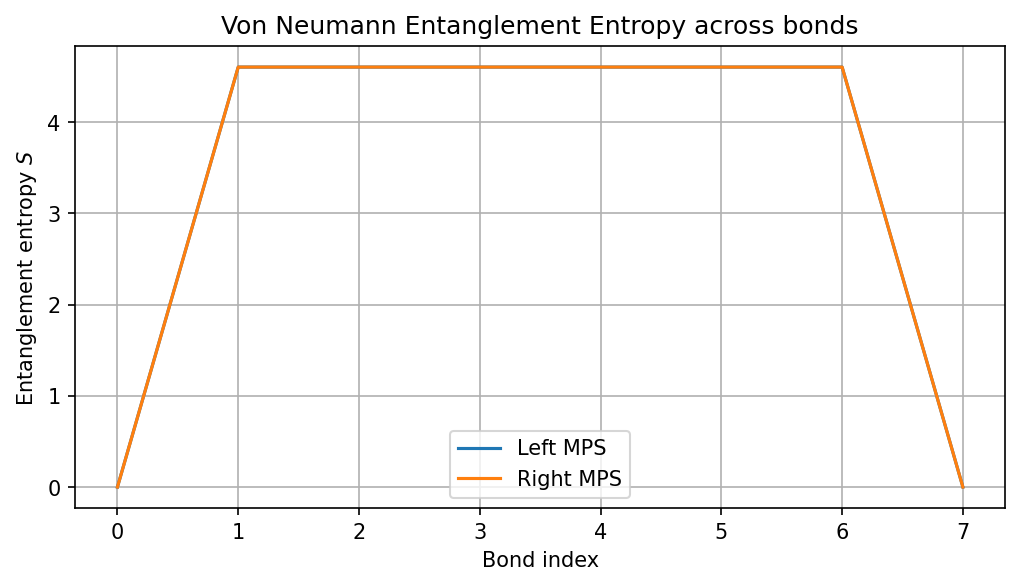

In [43]:
import matplotlib.pyplot as plt

def von_neumann_entropy_from_singular_values(s):
    s = s[s > 0]
    p = s**2 / np.sum(s**2)
    return -np.sum(p * np.log(p))

# Compute entanglement entropy across all bonds for left and right MPS
left_entropies = []
right_entropies = []

for state in [left_state, right_state]:
    entropies = []
    for tensor in state:
        # Reshape tensor to a matrix for SVD
        shape = tensor.shape
        mat = tensor.reshape(shape[0], -1)
        s = np.linalg.svd(mat, compute_uv=False)
        entropies.append(von_neumann_entropy_from_singular_values(s))
    if state is left_state:
        left_entropies = entropies
    else:
        right_entropies = entropies

plt.figure(figsize=(8, 4))
plt.plot(left_entropies, label='Left MPS')
plt.plot(right_entropies, label='Right MPS')
plt.xlabel('Bond index')
plt.ylabel('Entanglement entropy $S$')
plt.title('Von Neumann Entanglement Entropy across bonds')
plt.legend()
plt.grid(True)
plt.show()


Contracting site 1:
    Contracting MPS matrix: state (1, 2, 1) x column (1, 2, 1)
   Final truncated shape: (1, 100, 1))
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (100, 100, 1, 1))
    Contracting transfer matrix: state (2, 2, 1, 1) x column (2, 2, 1, 4)
   Final truncated shape: (100, 100, 1, 4))
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (100, 100, 1, 1))
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (100, 100, 1, 1))
    Contracting transfer matrix: state (2, 2, 1, 1) x column (2, 2, 1, 4)
   Final truncated shape: (100, 100, 1, 4))
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (100, 100, 1, 1))
    Contracting MPS matrix: state (1, 2, 1) x column (1, 2, 1)
   Final truncated shape: (1, 100, 1))
  Site 1 complete

Contracting site 2:
    Contracting MPS matrix: s

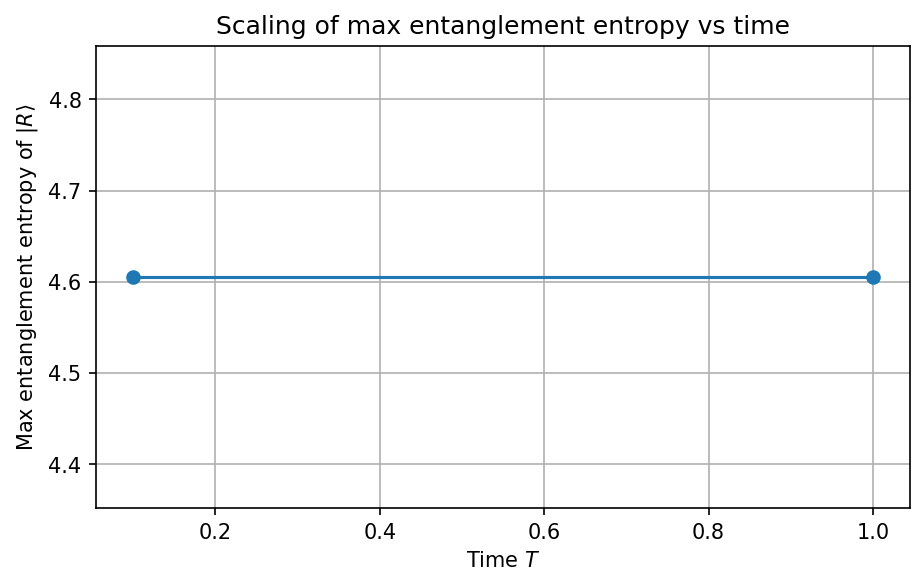

In [46]:
# For one additional point: scan T and plot max entropy of |R> vs T
import matplotlib.pyplot as plt
import numpy as np

# Choose time points (adjust as needed)
T_values = np.linspace(0.1, 4.0, 2)
max_entropies = []

for T_scan in T_values:
    E = build_transfer_matrices_columns(E_one_step, T=0.1)
    left_state, left_trunc_errs, left_bond_dims = left_effective_state(E)
    right_state, right_trunc_errs, right_bond_dims = right_effective_state(E)


    
    # Compute entanglement entropy for right_state
    entropies = []
    for tensor in right_state:
        shape = tensor.shape
        mat = tensor.reshape(shape[0], -1)
        s = np.linalg.svd(mat, compute_uv=False)
        s = s[s > 0]
        p = s**2 / np.sum(s**2)
        S = -np.sum(p * np.log(p))
        entropies.append(S)
    max_entropies.append(np.max(entropies))

plt.figure(figsize=(7, 4))
plt.plot(T_values, max_entropies, marker='o')
plt.xlabel('Time $T$')
plt.ylabel('Max entanglement entropy of $|R\\rangle$')
plt.title('Scaling of max entanglement entropy vs time')
plt.grid(True)
plt.show()

# Note: Replace the placeholder TN contraction with the actual update for E and right_state for each T.